*command enables matplotlib to use a Japanese

In [1]:
import os
import shutil
import urllib.request
import zipfile

# IPA フォント関係
ipa_zip_url = 'https://ipafont.ipa.go.jp/IPAexfont/ipaexg00301.zip'
ipa_font_dir = 'ipaexg00301'
ipa_zip_file = 'ipaexg00301.zip'
ipa_font_file = 'ipaexg.ttf'

# mpl ディレクトリ
mpl_dir = '/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/mpl-data'

# フォントキャッシュ
cache_dir = '/home/dsxuser/.cache/matplotlib'

# TTF フォントディレクトリ
ttf_font_dir = os.path.join(mpl_dir, 'fonts', 'ttf')

# ipaフォントパス(zipファイル内)
ipa_font_path = os.path.join(ipa_font_dir, ipa_font_file)

# フォントコピー先パス
dist_path = os.path.join(ttf_font_dir, ipa_font_file)

# matplorlibプロファイルパス
profile_path = os.path.join(mpl_dir, 'matplotlibrc')

# フォントキャッシュクリア
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

# check font path
print('checking %s' %ttf_font_dir)
if os.path.exists(ttf_font_dir):
    print('checking %s' %dist_path)
    if (os.path.exists(dist_path)):
        print('file %s already exist' % dist_path)
    else:
        print('donwload started')
        urllib.request.urlretrieve(ipa_zip_url, ipa_zip_file)
        with zipfile.ZipFile(ipa_zip_file) as f:
            print('unzip started')
            f.extract(ipa_font_path)
        print('copy started')
        shutil.copy(ipa_font_path, dist_path)
        with open(profile_path,'a') as f:
            f.write('font.family : IPAexGothic')
        print( 'IPA font %s copyed! Please restart kernel now.' % ipa_font_file)
else:    
    print('ERROR: font path %s does not exist!' % ttf_font_dir)

checking /opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf
checking /opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf
donwload started
unzip started
copy started
IPA font ipaexg.ttf copyed! Please restart kernel now.


# Residential choice support system

03/05/2020 Yuki Fujimaru

## Abstract

Similarity of the cities in Fukuoka, in Japan, was analyzed and clustered in the study. I extracted the factors which affect the clustering result in additon to just clustering them.

## Table of contents

+ lattitude and longitude in each city of Fukuoka were derived from http://tide.jpn.org/ll/?l=%E7%A6%8F%E5%B2%A1%E7%9C%8C.
+ Venues data in Fukuoka were obtained from Foursquare API. 
+ Landscape data in Fukuoka including ratio of land use, such as rice field, industrial site, and rive, rwere obtained from https://www.pref.fukuoka.lg.jp/uploaded/attachment/109588.pdf.
+ Merged data of Venues data and Landscape data were constructed.

## Introductory section (Business understnding & Analytic approach)

Working from home remotely is increasing these days. According to the survey performed by IPSOS, 20 % of the labor population in the world work from home. This work-style change is bringing a new life-style that people easily move to any countries and cities without considering their jobs. In some cases, people have no home and continue changing their resident at a span. Considering these changes, we need a data platform and services for these people to search cities and area information. However, there are not enough services offering an instant search about feature of destrict you want to know. 
    
  The city data, such as venues, public transportation, landscape, and amusement facilities, are differently placed. For example, we can access venue data through Foursquare, but landscape data are stored at Ministry of Agriculture, Forestry, and Fishers, and public transportation data are placed in Japan Railway or other private railways. It is necessary to gather these data and make structured dataframe for acieving the system offering district information to people who consider living there.
 
 In this project, I will construct the model describing similarity among cities in Fukuoka, my home town and one of the biggest district in Japan, by k-means clustering. Moreover, I will visualize which featres contribute to a separation among clusters by Partial Least Square regression Discriminant Anlysis (PLS-DA).  

## Methodology section (Data requirement & Data collection & Data understanding & Data preparation)

To solve the adressed problem, the data including venues, landscape, public transportation in the cities in Fukuoka were collected.

## $Venues$ $data$

I got the data of venues in Fukuoka through Foursquare API by the following code

### Download latitude and longitude of cities in Fukuoka

In [2]:
import pandas as pd
url='http://tide.jpn.org/ll/?l=%E7%A6%8F%E5%B2%A1%E7%9C%8C'

df = pd.read_html(url,header=0)

In [3]:
df_latlog=df[0]
df_latlog2=df_latlog.drop(index=30).reset_index(drop=True)
df_latlog2.dtypes

市町村     object
緯度      object
経度      object
参考地点    object
dtype: object

### Call Venues data from Foursquare

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

CLIENT_ID = '4XKVNDTMG0HKCUESIL3B0XS10R1ZPOMLNKHU2TZORV1GBAMT'
CLIENT_SECRET = 'VD3O0DHE4TXGG03CHQLNVLGTHVFLGKD2VF42DBI2X0FNITE3'
VERSION = '20180604'
LIMIT = 30

Fukuoka_venues=getNearbyVenues(names=df_latlog2['市町村'], latitudes=df_latlog2['緯度'].astype(np.float), longitudes=df_latlog2['経度'].astype(np.float))

北九州市門司区
北九州市若松区
北九州市戸畑区
北九州市小倉北区
北九州市小倉南区
北九州市八幡東区
北九州市八幡西区
福岡市東区
福岡市博多区
福岡市中央区
福岡市南区
福岡市西区
福岡市城南区
福岡市早良区
大牟田市
久留米市
直方市
飯塚市
田川市
柳川市
八女市
筑後市
大川市
行橋市
豊前市
中間市
小郡市
筑紫野市
春日市
大野城市
宗像市
太宰府市
古賀市
福津市
うきは市
宮若市
嘉麻市
朝倉市
みやま市
糸島市
筑紫郡那珂川町
糟屋郡宇美町
糟屋郡篠栗町
糟屋郡志免町
糟屋郡須恵町
糟屋郡新宮町
糟屋郡久山町
糟屋郡粕屋町
遠賀郡芦屋町
遠賀郡水巻町
遠賀郡岡垣町
遠賀郡遠賀町
鞍手郡小竹町
鞍手郡鞍手町
嘉穂郡桂川町
朝倉郡筑前町
朝倉郡東峰村
三井郡大刀洗町
三潴郡大木町
八女郡広川町
田川郡香春町
田川郡添田町
田川郡川崎町
田川郡大任町
田川郡赤村
田川郡福智町
京都郡苅田町
京都郡みやこ町
築上郡吉富町
築上郡上毛町
築上郡築上町


### Data arrangement

In [6]:
# one hot encoding
Fukuoka_onehot = pd.get_dummies(Fukuoka_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Fukuoka_onehot['Neighborhood'] = Fukuoka_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Fukuoka_onehot.columns[-1]] + list(Fukuoka_onehot.columns[:-1])
Fukuoka_onehot = Fukuoka_onehot[fixed_columns]

In [7]:
Fukuoka_grouped = Fukuoka_onehot.groupby('Neighborhood').mean().reset_index()
Fukuoka_grouped.head()


,Neighborhood,Adult Boutique,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Bike Shop,Boat or Ferry,Bookstore,Bridal Shop,Bridge,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Castle,Chinese Restaurant,City Hall,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Convention Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Fishing Store,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Karaoke Bar,Karaoke Box,Korean Restaurant,Lake,Liquor Store,Market,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Nabe Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Outdoor Sculpture,Outdoor Supply Store,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Rental Service,Reservoir,Rest Area,Restaurant,River,Sake Bar,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Takoyaki Place,Tea Room,Tempura Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Video Store,Vineyard,Wagashi Place,Water Park,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant,Zoo
0,うきは市,0.0,0.0,0.000000,0.0,0.0625,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0625,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.000000,0.0,0.0625,0.0,0.0,0.0,0.0,0.0
1,みやま市,0.0,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.1,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,三井郡大刀洗町,0.0,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [8]:
kita=Fukuoka_grouped[Fukuoka_grouped['Neighborhood'].str.contains('北九州市')]
kk=kita.mean(axis=0)
kk['Neighborhood']='北九州市'
list=kita['Neighborhood'].tolist()
Fukuoka_kita=Fukuoka_grouped.query('Neighborhood != list')
Fukuoka_kita.loc['61']=kk

fuku=Fukuoka_kita[Fukuoka_kita['Neighborhood'].str.contains('福岡市')]
fk=fuku.mean(axis=0)
fk['Neighborhood']='福岡市'
list=fuku['Neighborhood'].tolist()
Fukuoka_fuku=Fukuoka_kita.query('Neighborhood != list')
Fukuoka_fuku.loc['62']=fk
Fukuoka_arranging=Fukuoka_fuku.reset_index(drop=True)
Fukuoka_arranging.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Neighborhood,Adult Boutique,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Bike Shop,Boat or Ferry,Bookstore,Bridal Shop,Bridge,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Castle,Chinese Restaurant,City Hall,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Convention Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Fishing Store,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Karaoke Bar,Karaoke Box,Korean Restaurant,Lake,Liquor Store,Market,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Nabe Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Outdoor Sculpture,Outdoor Supply Store,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Rental Service,Reservoir,Rest Area,Restaurant,River,Sake Bar,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Takoyaki Place,Tea Room,Tempura Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Video Store,Vineyard,Wagashi Place,Water Park,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant,Zoo
0,うきは市,0.0,0.0,0.000000,0.0,0.0625,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.125000,0.0,0.000000,0.0,0.000000,0.0625,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.000000,0.0,0.0625,0.0,0.0,0.0,0.0,0.0
1,みやま市,0.0,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.1,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,三井郡大刀洗町,0.0,0.0,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [9]:
Fukuoka_1=Fukuoka_arranging['Neighborhood'].str.lstrip('鞍手郡')
Fukuoka_1rp=Fukuoka_1.replace('町','鞍手町')
Fukuoka_arranging1=Fukuoka_arranging
Fukuoka_arranging1['Neighborhood']=Fukuoka_1rp

Fukuoka_2=Fukuoka_arranging1['Neighborhood'].str.lstrip('三潴郡')
Fukuoka_2rp=Fukuoka_2.replace('町','三潴町')
Fukuoka_arranging2=Fukuoka_arranging1
Fukuoka_arranging2['Neighborhood']=Fukuoka_2rp

Fukuoka_3=Fukuoka_arranging2['Neighborhood'].str.lstrip('京都郡')
Fukuoka_3rp=Fukuoka_3.replace('町','京都町')
Fukuoka_arranging3=Fukuoka_arranging2
Fukuoka_arranging3['Neighborhood']=Fukuoka_3rp

Fukuoka_4=Fukuoka_arranging3['Neighborhood'].str.lstrip('八女郡')
Fukuoka_4rp=Fukuoka_4.replace('市','八女市')
Fukuoka_arranging4=Fukuoka_arranging3
Fukuoka_arranging4['Neighborhood']=Fukuoka_4rp

Fukuoka_5=Fukuoka_arranging4['Neighborhood'].str.lstrip('嘉穂郡')
Fukuoka_5rp=Fukuoka_5.replace('町','嘉穂町')
Fukuoka_5rp2=Fukuoka_5rp.replace('麻市','嘉麻市')
Fukuoka_arranging5=Fukuoka_arranging4
Fukuoka_arranging5['Neighborhood']=Fukuoka_5rp2

Fukuoka_6=Fukuoka_arranging5['Neighborhood'].str.lstrip('朝倉郡')
Fukuoka_6rp=Fukuoka_6.replace('市','朝倉市')
Fukuoka_arranging6=Fukuoka_arranging5
Fukuoka_arranging6['Neighborhood']=Fukuoka_6rp

Fukuoka_7=Fukuoka_arranging6['Neighborhood'].str.lstrip('田川郡')
Fukuoka_7rp=Fukuoka_7.replace('市','田川市')
Fukuoka_7rp2=Fukuoka_7rp.replace('崎町','川崎町')
Fukuoka_arranging7=Fukuoka_arranging6
Fukuoka_arranging7['Neighborhood']=Fukuoka_7rp2

Fukuoka_8=Fukuoka_arranging7['Neighborhood'].str.lstrip('筑紫野郡')
Fukuoka_8rp=Fukuoka_8.replace('市','筑紫野市')
Fukuoka_8rp2=Fukuoka_8rp.replace('前町','筑前町')
Fukuoka_8rp3=Fukuoka_8rp2.replace('後市','筑後市')
Fukuoka_arranging8=Fukuoka_arranging7
Fukuoka_arranging8['Neighborhood']=Fukuoka_8rp3

Fukuoka_9=Fukuoka_arranging8['Neighborhood'].str.lstrip('築上郡')
Fukuoka_9rp=Fukuoka_9.replace('町','築上町')
Fukuoka_9rp2=Fukuoka_9rp.replace('毛町','上毛町')
Fukuoka_arranging9=Fukuoka_arranging8
Fukuoka_arranging9['Neighborhood']=Fukuoka_9rp2

Fukuoka_10=Fukuoka_arranging9['Neighborhood'].str.lstrip('糟屋郡')
Fukuoka_10rp=Fukuoka_10.replace('町','糟屋町')
Fukuoka_arranging10=Fukuoka_arranging9
Fukuoka_arranging10['Neighborhood']=Fukuoka_10rp

Fukuoka_11=Fukuoka_arranging10['Neighborhood'].str.lstrip('遠賀郡')
Fukuoka_11rp=Fukuoka_11.replace('町','遠賀町')
Fukuoka_arranging11=Fukuoka_arranging10
Fukuoka_arranging11['Neighborhood']=Fukuoka_11rp

Fukuoka_12=Fukuoka_arranging11['Neighborhood'].str.lstrip('井郡')
Fukuoka_12rp=Fukuoka_12.replace('町','井町')
Fukuoka_arranged=Fukuoka_arranging11
Fukuoka_arranged['Neighborhood']=Fukuoka_12rp


Fukuoka_arranged

,Neighborhood,Adult Boutique,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Bike Shop,Boat or Ferry,Bookstore,Bridal Shop,Bridge,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Castle,Chinese Restaurant,City Hall,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Convention Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Fishing Store,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Karaoke Bar,Karaoke Box,Korean Restaurant,Lake,Liquor Store,Market,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Multiplex,Museum,Nabe Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Outdoor Sculpture,Outdoor Supply Store,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Rental Service,Reservoir,Rest Area,Restaurant,River,Sake Bar,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sri Lankan Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Takoyaki Place,Tea Room,Tempura Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Used Bookstore,Video Store,Vineyard,Wagashi Place,Water Park,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant,Zoo
0,うきは市,0.0,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.000000,0.0,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000
1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [10]:
num_top_venues = 7
top5=[]
for hood in Fukuoka_arranged['Neighborhood']:
    print("----"+hood+"----")
    temp = Fukuoka_arranged[Fukuoka_arranged['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
    top=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    top5.extend(top['venue'])


----うきは市----
----みやま市----
----大刀洗町----
----大木町----
----中間市----
----久留米市----
----みやこ町----
----苅田町----
----八女市----
----広川町----
----古賀市----
----桂川町----
----嘉麻市----
----大川市----
----大牟田市----
----大野城市----
----太宰府市----
----宗像市----
----宮若市----
----小郡市----
----春日市----
----朝倉市----
----東峰村----
----筑前町----
----柳川市----
----田川市----
----大任町----
----川崎町----
----添田町----
----福智町----
----赤村----
----香春町----
----直方市----
----福津市----
----筑後市----
----那珂川町----
----筑紫野市----
----上毛町----
----吉富町----
----築上町----
----久山町----
----宇美町----
----志免町----
----新宮町----
----篠栗町----
----粕屋町----
----須恵町----
----糸島市----
----行橋市----
----豊前市----
----岡垣町----
----水巻町----
----芦屋町----
----遠賀町----
----小竹町----
----鞍手町----
----飯塚市----
----北九州市----
----福岡市----


In [11]:
top5.append('Neighborhood')
iotop5=Fukuoka_arranged.columns[~Fukuoka_arranged.columns.isin(top5),].tolist()

In [12]:
Fukuoka_arranged=Fukuoka_arranged.drop(iotop5,1)
Fukuoka_arranged.head()

,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo
0,うきは市,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.125000,0.0,0.000000,0.0625,0.125000,0.0,0.0,0.0,0.0625,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,みやま市,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.1,0.000000,0.0,0.000000,0.0000,0.400000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,大刀洗町,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.375000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,大木町,0.0,0.0000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.333333,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,中間市,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.033333,0.0,0.066667,0.0000,0.233333,0.0,0.0,0.0,0.0000,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.066667,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.1,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.033333,0.0,0.0,0.0,0.0,0.0


In [13]:
Fukuoka_arranged.shape

(59, 100)

## $Landscape$ $data$

I got landscape data in Fukuoka through web site at Fukuoka Prefectural Government.

### Download landscape data from web pdf file

In [14]:
!pip uninstall tabula-py -y

Uninstalling tabula-py-2.1.0:
  Successfully uninstalled tabula-py-2.1.0


In [15]:
!pip install tabula-py
import tabula

  Using cached https://files.pythonhosted.org/packages/53/a4/66add528eca00398af98f181772006750019eb9f2d68c7c6fdd53ba661c5/tabula_py-2.1.0-py3-none-any.whl


In [16]:

PDF_PATH = 'https://www.pref.fukuoka.lg.jp/uploaded/attachment/109588.pdf'

import tabula
dfl=tabula.read_pdf(PDF_PATH, pages = "15")
dfl_arranging=dfl[0]

### Arranging landscape data

In [17]:
dfl_arranging.head()

,Unnamed: 0,Unnamed: 1,市町村面積,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,市街地
0,NaN,NaN,NaN,農地,NaN,NaN,森林,NaN,NaN,原野等水面・河川・水路,NaN,NaN,NaN,道路,NaN,NaN,NaN,宅地,NaN,NaN,NaN,その他,NaN
1,NaN,NaN,NaN,NaN,田,畑,NaN,国有林,民有林,NaN,水面,河川,水路,NaN,一般道路,農道,林道,NaN,住宅地,工業用地,その他宅地,NaN,NaN
2,NaN,NaN,NaN,=a+b,a,b,=c+d,c,d,=e+f+g,e,f,g,=h+i+j,h,i,j,=k+l+m,k,l,m,NaN,NaN
3,福岡県,NaN,"498,652","81,300","65,100","16,200","222,251","25,023","197,228","424 21,657","4,027","12,668","4,962","32,877","29,245","1,815","1,817","75,796","46,082","5,701","24,013","64,347","56,660"
4,福岡地域,NaN,"153,767","20,073","15,997","4,076","69,039","11,064","57,975","159 4,984","1,522","2,528",934,"11,265","10,117",451,697,"27,232","17,245",851,"9,136","21,015","26,553"


In [18]:
dfl_arranging2=dfl_arranging.rename(columns={'Unnamed: 1':'Neighborhood','市町村面積':'Total area','Unnamed: 2':'Farmland','Unnamed: 3':'Rice Field','Unnamed: 4':'Field',
                              'Unnamed: 5':'Forest','Unnamed: 9':'Pond','Unnamed: 10':'River','Unnamed: 11':'Water Way','Unnamed: 13':'Road','Unnamed: 14':'Farm Road',
                              'Unnamed: 15':'Woodland Path','Unnamed: 17':'Resident','Unnamed: 18':'Industrial Site','市街地':'Town Area'})

In [19]:
de=range(5)
for i in de:
 dfl_arranging3=dfl_arranging2.drop(de).reset_index(drop=True)
dfl_arranging3.head()

,Unnamed: 0,Neighborhood,Total area,Farmland,Rice Field,Field,Forest,Unnamed: 6,Unnamed: 7,Unnamed: 8,Pond,River,Water Way,Unnamed: 12,Road,Farm Road,Woodland Path,Unnamed: 16,Resident,Industrial Site,Unnamed: 19,Unnamed: 20,Town Area
0,40130,福岡市,"34,346","1,809","1,520",289,"10,959","2,541","8,418","71 1,024",232,706,86,"3,482","3,358",39,85,"11,364","6,961",162,"4,241","5,637","15,435"
1,40217,筑紫野市,"8,773",903,832,71,"4,429",530,"3,899",0 218,50,125,43,625,571,6,48,"1,333",885,47,401,"1,265",989
2,40218,春日市,"1,415",23,13,10,63,0,63,0 43,37,5,1,213,213,0,0,799,577,7,215,274,"1,328"
3,40219,大野城市,"2,689",51,44,7,"1,021",16,"1,005",0 96,46,48,2,318,304,0,14,860,592,16,252,343,"1,199"
4,40220,宗像市,"11,994","2,063","1,570",493,"5,015",328,"4,687",55 376,172,107,97,899,827,44,28,"1,745","1,193",11,541,"1,841",948


In [20]:
dfl_arranging4=dfl_arranging3.drop(['Unnamed: 0','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 12','Unnamed: 16','Unnamed: 19','Unnamed: 20'],axis=1)
dfl_arranging4.reset_index(drop=True)
dfl_arranging4.head()

,Neighborhood,Total area,Farmland,Rice Field,Field,Forest,Pond,River,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,福岡市,"34,346","1,809","1,520",289,"10,959",232,706,86,"3,358",39,85,"6,961",162,"15,435"
1,筑紫野市,"8,773",903,832,71,"4,429",50,125,43,571,6,48,885,47,989
2,春日市,"1,415",23,13,10,63,37,5,1,213,0,0,577,7,"1,328"
3,大野城市,"2,689",51,44,7,"1,021",46,48,2,304,0,14,592,16,"1,199"
4,宗像市,"11,994","2,063","1,570",493,"5,015",172,107,97,827,44,28,"1,193",11,948


In [21]:
dfl_arranged=dfl_arranging4.drop([20,33,44,49]).reset_index(drop=True)
lis=[2,3,4,5,6,7,8,9,10,11,12,13,14]
dfl_arranged['Total area']=dfl_arranged['Total area'].str.replace(',','').astype(float)
for i in lis:
 dfl_arranged.iloc[:,i]=dfl_arranged.iloc[:,i].str.replace(',','').astype(float)/dfl_arranged['Total area']


In [22]:
dfl_arranged=dfl_arranged.drop('Total area',axis=1)

In [23]:
dfl_arranged.loc[10,'Neighborhood']='那珂川町'

In [24]:
dfl_arranged

,Neighborhood,Farmland,Rice Field,Field,Forest,Pond,River,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,福岡市,0.052670,0.044256,0.008414,0.319076,0.006755,0.020556,0.002504,0.097770,0.001136,0.002475,0.202673,0.004717,0.449397
1,筑紫野市,0.102929,0.094836,0.008093,0.504844,0.005699,0.014248,0.004901,0.065086,0.000684,0.005471,0.100878,0.005357,0.112732
2,春日市,0.016254,0.009187,0.007067,0.044523,0.026148,0.003534,0.000707,0.150530,0.000000,0.000000,0.407774,0.004947,0.938516
3,大野城市,0.018966,0.016363,0.002603,0.379695,0.017107,0.017851,0.000744,0.113053,0.000000,0.005206,0.220156,0.005950,0.445891
4,宗像市,0.172003,0.130899,0.041104,0.418126,0.014341,0.008921,0.008087,0.068951,0.003669,0.002335,0.099466,0.000917,0.079040
5,太宰府市,0.047297,0.042905,0.004392,0.398986,0.008108,0.009122,0.001689,0.095946,0.000000,0.002703,0.190541,0.003041,0.330068
6,古賀市,0.118374,0.094842,0.023532,0.327312,0.011647,0.014024,0.004041,0.081293,0.000713,0.003803,0.119325,0.022106,0.144046
7,福津市,0.220243,0.164898,0.055345,0.257582,0.015542,0.006065,0.008719,0.083586,0.000000,0.000758,0.126990,0.002274,0.145186
8,朝倉市,0.199019,0.139435,0.059584,0.548377,0.013579,0.027482,0.008350,0.039398,0.006810,0.005188,0.047140,0.010336,0.011268
9,糸島市,0.197218,0.162262,0.034956,0.454149,0.004914,0.014696,0.010107,0.046592,0.006305,0.006073,0.063329,0.001901,0.034261


## $Public$ $transportation$ $data$

As this data cost a lot of money, I am going to next step at the time. If the K-means clustering dose not work well, I will back here to collect this data.

## $Combine$ $Venues$ $data$ & $Landscape$ $data$

In [25]:
dataset_kmeans=pd.merge(Fukuoka_arranged, dfl_arranged, on='Neighborhood',how='outer')

In [26]:
dataset_kmeans

,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,うきは市,0.0,0.062500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000
1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000
2,大刀洗町,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.0

It was accomplished that all of the variables in data except 'Neighborhood' are float type, which means the data can be applied to modeling.

## Result

### K-means clustering divided cities in Fukuoka into 5 groups

K-means clustering

In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

     |████████████████████████████████| 92kB 19.2MB/s eta 0:00:01


In [28]:
# set number of clusters
kclusters = 5

Fukuoka_clustering = dataset_kmeans.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Fukuoka_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([4, 1, 1, 1, 0, 1, 4, 2, 4, 2], dtype=int32)

Mapping clustering result on map

In [29]:
# add clustering labels
dataset_kmeans.insert(0, 'Cluster Labels', kmeans.labels_)


In [30]:
dataset_pls=dataset_kmeans
dataset_pls

,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,4,うきは市,0.0,0.062500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000
1,1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000
2,1,大刀洗町,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0000,0.000000,

In [31]:
df_latlog2['経度']=df_latlog2['経度'].astype(float)
df_latlog2['緯度']=df_latlog2['緯度'].astype(float)

In [32]:
kita=df_latlog2[df_latlog2['市町村'].str.contains('北九州市')]
kk=kita.mean(axis=0)
kk['市町村']='北九州市'
list=kita['市町村'].tolist()
Fukuoka_kita=df_latlog2.query('市町村 != list')
Fukuoka_kita.loc['61']=kk

fuku=Fukuoka_kita[Fukuoka_kita['市町村'].str.contains('福岡市')]
fk=fuku.mean(axis=0)
fk['市町村']='福岡市'
list=fuku['市町村'].tolist()
Fukuoka_fuku=Fukuoka_kita.query('市町村 != list')
Fukuoka_fuku.loc['62']=fk
latlog_arranging=Fukuoka_fuku.reset_index(drop=True)
latlog_arranging

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,市町村,緯度,経度,参考地点
0,大牟田市,33.017146,130.460387,青葉町
1,久留米市,33.313495,130.538246,合川町
2,直方市,33.728356,130.728331,大字赤地
3,飯塚市,33.670933,130.649704,相田
4,田川市,33.643903,130.814115,伊田町
5,柳川市,33.168448,130.410958,曙町
6,八女市,33.207555,130.549345,稲富
7,筑後市,33.207351,130.494048,大字和泉
8,大川市,33.200967,130.383700,大字上巻
9,行橋市,33.715394,130.978589,泉中央一丁目


In [33]:
latlog_arranging=latlog_arranging.rename(columns={'市町村':'Neighborhood','緯度':'Latitudes','経度':'Longiudes'})

In [34]:
Fukuoka_1=latlog_arranging['Neighborhood'].str.lstrip('鞍手郡')
Fukuoka_1rp=Fukuoka_1.replace('町','鞍手町')
Fukuoka_arranging1=latlog_arranging
Fukuoka_arranging1['Neighborhood']=Fukuoka_1rp

Fukuoka_2=Fukuoka_arranging1['Neighborhood'].str.lstrip('三潴郡')
Fukuoka_2rp=Fukuoka_2.replace('町','三潴町')
Fukuoka_arranging2=Fukuoka_arranging1
Fukuoka_arranging2['Neighborhood']=Fukuoka_2rp

Fukuoka_3=Fukuoka_arranging2['Neighborhood'].str.lstrip('京都郡')
Fukuoka_3rp=Fukuoka_3.replace('町','京都町')
Fukuoka_arranging3=Fukuoka_arranging2
Fukuoka_arranging3['Neighborhood']=Fukuoka_3rp

Fukuoka_4=Fukuoka_arranging3['Neighborhood'].str.lstrip('八女郡')
Fukuoka_4rp=Fukuoka_4.replace('市','八女市')
Fukuoka_arranging4=Fukuoka_arranging3
Fukuoka_arranging4['Neighborhood']=Fukuoka_4rp

Fukuoka_5=Fukuoka_arranging4['Neighborhood'].str.lstrip('嘉穂郡')
Fukuoka_5rp=Fukuoka_5.replace('町','嘉穂町')
Fukuoka_5rp2=Fukuoka_5rp.replace('麻市','嘉麻市')
Fukuoka_arranging5=Fukuoka_arranging4
Fukuoka_arranging5['Neighborhood']=Fukuoka_5rp2

Fukuoka_6=Fukuoka_arranging5['Neighborhood'].str.lstrip('朝倉郡')
Fukuoka_6rp=Fukuoka_6.replace('市','朝倉市')
Fukuoka_arranging6=Fukuoka_arranging5
Fukuoka_arranging6['Neighborhood']=Fukuoka_6rp

Fukuoka_7=Fukuoka_arranging6['Neighborhood'].str.lstrip('田川郡')
Fukuoka_7rp=Fukuoka_7.replace('市','田川市')
Fukuoka_7rp2=Fukuoka_7rp.replace('崎町','川崎町')
Fukuoka_arranging7=Fukuoka_arranging6
Fukuoka_arranging7['Neighborhood']=Fukuoka_7rp2

Fukuoka_8=Fukuoka_arranging7['Neighborhood'].str.lstrip('筑紫野郡')
Fukuoka_8rp=Fukuoka_8.replace('市','筑紫野市')
Fukuoka_8rp2=Fukuoka_8rp.replace('前町','筑前町')
Fukuoka_8rp3=Fukuoka_8rp2.replace('後市','筑後市')
Fukuoka_arranging8=Fukuoka_arranging7
Fukuoka_arranging8['Neighborhood']=Fukuoka_8rp3

Fukuoka_9=Fukuoka_arranging8['Neighborhood'].str.lstrip('築上郡')
Fukuoka_9rp=Fukuoka_9.replace('町','築上町')
Fukuoka_9rp2=Fukuoka_9rp.replace('毛町','上毛町')
Fukuoka_arranging9=Fukuoka_arranging8
Fukuoka_arranging9['Neighborhood']=Fukuoka_9rp2

Fukuoka_10=Fukuoka_arranging9['Neighborhood'].str.lstrip('糟屋郡')
Fukuoka_10rp=Fukuoka_10.replace('町','糟屋町')
Fukuoka_arranging10=Fukuoka_arranging9
Fukuoka_arranging10['Neighborhood']=Fukuoka_10rp

Fukuoka_11=Fukuoka_arranging10['Neighborhood'].str.lstrip('遠賀郡')
Fukuoka_11rp=Fukuoka_11.replace('町','遠賀町')
Fukuoka_arranging11=Fukuoka_arranging10
Fukuoka_arranging11['Neighborhood']=Fukuoka_11rp

Fukuoka_12=Fukuoka_arranging11['Neighborhood'].str.lstrip('井郡')
Fukuoka_12rp=Fukuoka_12.replace('町','井町')
latlog_arranged=Fukuoka_arranging11
latlog_arranged['Neighborhood']=Fukuoka_12rp

latlog_arranged

,Neighborhood,Latitudes,Longiudes,参考地点
0,大牟田市,33.017146,130.460387,青葉町
1,久留米市,33.313495,130.538246,合川町
2,直方市,33.728356,130.728331,大字赤地
3,飯塚市,33.670933,130.649704,相田
4,田川市,33.643903,130.814115,伊田町
5,柳川市,33.168448,130.410958,曙町
6,八女市,33.207555,130.549345,稲富
7,筑後市,33.207351,130.494048,大字和泉
8,大川市,33.200967,130.383700,大字上巻
9,行橋市,33.715394,130.978589,泉中央一丁目


In [35]:
dataset_map=pd.merge(dataset_pls,latlog_arranged, on='Neighborhood')
dataset_map

,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area,Latitudes,Longiudes,参考地点
0,4,うきは市,0.0,0.062500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000,33.330546,130.792127,浮羽町朝田
1,1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000,33.163429,130.481244,瀬高町文廣
2,1,大刀洗町,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [66]:
latitude=33.607
longitude=130.418
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
cl3=[]
for i in (dataset_map['Cluster Labels']).astype(int):
 cl3.append(colorlist[i])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dataset_map['Latitudes'], dataset_map['Longiudes'], dataset_map['Neighborhood'].str.decode('utf-8'), cl3):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster,
        fill=True,
        fill_color=cluster,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### PLS-DA revealed the important factors which divide the cities into clusters

In [37]:
from sklearn import cross_decomposition

In [38]:
dataset_plsda = pd.get_dummies(dataset_pls['Cluster Labels'], prefix="", prefix_sep="")

In [39]:

dataset_plsda=pd.merge(dataset_plsda,dataset_pls,left_index=True,right_index=True)
dataset_plsda

,0,1,2,3,4,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,0,0,0,0,1,4,うきは市,0.0,0.062500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000
1,0,1,0,0,0,1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000
2,0,1,0,0,0,1,大刀洗町,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [40]:
dataset_plsda.iloc[:,0:10]

,0,1,2,3,4,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports
0,0,0,0,0,1,4,うきは市,0.0,0.062500,0.000000
1,0,1,0,0,0,1,みやま市,0.0,0.000000,0.000000
2,0,1,0,0,0,1,大刀洗町,0.0,0.000000,0.000000
3,0,1,0,0,0,1,大木町,0.0,0.000000,0.000000
4,1,0,0,0,0,0,中間市,0.0,0.000000,0.000000
5,0,1,0,0,0,1,久留米市,0.0,0.000000,0.000000
6,0,0,0,0,1,4,みやこ町,0.0,0.166667,0.000000
7,0,0,1,0,0,2,苅田町,0.0,0.000000,0.000000
8,0,0,0,0,1,4,八女市,0.0,0.050000,0.000000
9,0,0,1,0,0,2,広川町,0.0,0.000000,0.000000


Fitting model and cross-validation

In [41]:
Q=[]

while len(Q)<9:
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(dataset_plsda.iloc[:,5:189], dataset_plsda.iloc[:,0:5],test_size=0.1)
 X_train=X_train.iloc[:,2:182]

 pls = cross_decomposition.PLSRegression(n_components=4, scale=False, max_iter=500, tol=1e-06, copy=True)
 model=pls.fit(X_train, y_train)
 print(pls.score(X_train,y_train))

 y_test=y_test[y_test['3']!=1]
 X_test=X_test[X_test['Cluster Labels']!=3]
 X_test=X_test.iloc[:,2:180]

 Q.append(pls.score(X_test,y_test))

0.6955400293063285
0.6705509764276582
0.6804462974298412
0.7255893255303988
0.7191238006312923
0.6807350643224644
0.6836801780072722
0.6557181370076861
0.6838704655683799


In [42]:
sum(Q)/9


0.5930317233525909

Visualizatio of pls-da annalysis

In [43]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt



In [44]:
dataset_plsda.head()

,0,1,2,3,4,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area
0,0,0,0,0,1,4,うきは市,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.125000,0.0,0.000000,0.0625,0.125000,0.0,0.0,0.0,0.0625,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000
1,0,1,0,0,0,1,みやま市,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.1,0.000000,0.0,0.000000,0.0000,0.400000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000
2,0,1,0,0,0,1,大刀洗町,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.375000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.573993,0.525394,0.048599,0.000000,0.001313,0.054729,0.032837,0.080123,0.000876,0.000000,0.123030,0.006130,0.000000
3,0,1,0,0,0,1,大木町,0.0,0.0000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.333333,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.531996,0.528200,0.003796,0.000000,0.000000,0.009219,0.075380,0.088395,0.001085,0.0000

In [45]:
x=dataset_plsda.iloc[:,7:189]
y=dataset_plsda.iloc[:,0:5]
pls = cross_decomposition.PLSRegression(n_components=4, scale=False, max_iter=500, tol=1e-06, copy=True)
model=pls.fit(x, y)

In [46]:
t1=model.x_scores_[:,0]
t2=model.x_scores_[:,1]
t3=model.x_scores_[:,2]
t4=model.x_scores_[:,3]
t1.shape

(59,)

In [47]:
dataset_plsda['t1']=t1
dataset_plsda['t2']=t2
dataset_plsda['t3']=t3
dataset_plsda['t4']=t4
dataset_plsda.head()

,0,1,2,3,4,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area,t1,t2,t3,t4
0,0,0,0,0,1,4,うきは市,0.0,0.0625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.125000,0.0,0.000000,0.0625,0.125000,0.0,0.0,0.0,0.0625,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000,0.180140,-0.092238,-0.056368,-0.085905
1,0,1,0,0,0,1,みやま市,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.1,0.000000,0.0,0.000000,0.0000,0.400000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000,-0.221539,-0.299238,0.093303,0.002959
2,0,1,0,0,0,1,大刀洗町,0.0,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.375000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.573993,0.525394,0.048599,0.000000,0.001313,0.054729,0.032837,0.080123,0.000876,0.000000,0.123030,0.006130,0.000000,-0.453969,-0.498024,-0.015999,-0.059713
3,0,1,0,0,0,1,大木町,0.0,0.0000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.000000,0.0000,0.333333,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,

In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.scroll_box { height:30em  !important; }</style>"))

In [49]:
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
cl=[]
for i in (dataset_plsda['Cluster Labels']).astype(int):
 cl.append(colorlist[i])

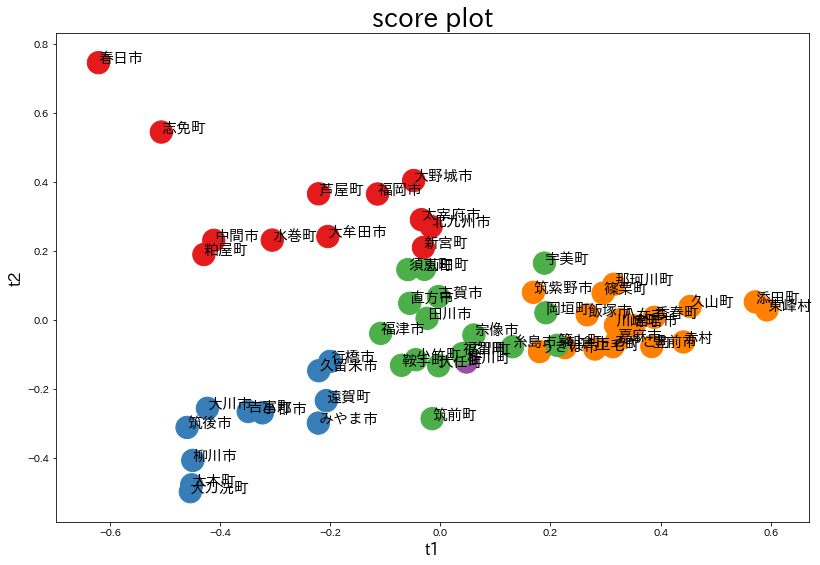

In [50]:
%matplotlib inline
ax=dataset_plsda.plot(kind='scatter', x='t1', y='t2',figsize=(13.5,9),color=cl,s=500)
for x, y, n in zip(dataset_plsda['t1'], dataset_plsda['t2'], dataset_plsda['Neighborhood']):
                   ax.text(x,y,n,fontsize=15)
ax.set_xlabel('t1',fontsize=16)
ax.set_ylabel('t2',fontsize=16)
ax.set_title('score plot',fontsize=26)
plt.show()

In [51]:
w1=model.x_weights_[:,0]
w2=model.x_weights_[:,1]
w3=model.x_weights_[:,2]
w4=model.x_weights_[:,3]
w1.shape

(112,)

In [52]:
weight_name1=dataset_plsda.columns.drop(['0','1','2','3','4','Cluster Labels','Neighborhood','t1','t2','t3','t4'],1).tolist()

In [53]:
len(weight_name1)

112

In [54]:
weightdf=pd.DataFrame({'variable_name':weight_name1, 'w1':w1, 'w2':w2, 'w3':w3, 'w4':w4})

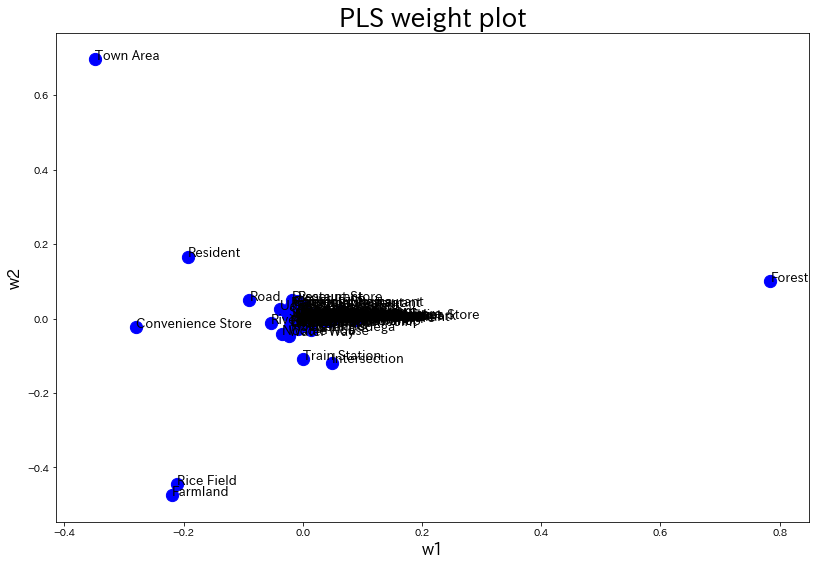

In [55]:
axw=weightdf.plot(kind='scatter', x='w1', y='w2',figsize=(13.5,9),color='blue',s=150)
for x, y, n in zip(weightdf['w1'], weightdf['w2'], weightdf['variable_name']):
                   axw.text(x,y,n,fontsize=13)
axw.set_xlabel('w1',fontsize=16)
axw.set_ylabel('w2',fontsize=16)
axw.set_title('PLS weight plot',fontsize=26)
plt.show()

In [56]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [57]:
dataset_plsda

,0,1,2,3,4,Cluster Labels,Neighborhood,Adult Boutique,Arts & Crafts Store,Athletics & Sports,Auto Garage,BBQ Joint,Baseball Stadium,Basketball Court,Bookstore,Bridal Shop,Bus Station,Bus Stop,Café,City Hall,Clothing Store,Coffee Shop,Convenience Store,Deli / Bodega,Dessert Shop,Diner,Discount Store,Donburi Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Golf Course,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hot Spring,Hotel,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Box,Korean Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mountain,Moving Target,Nabe Restaurant,Noodle House,Okonomiyaki Restaurant,Pachinko Parlor,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pharmacy,Pizza Place,Playground,Pub,Public Bathroom,Ramen Restaurant,Reservoir,Rest Area,Restaurant,River_x,Sake Bar,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soba Restaurant,Souvenir Shop,Spa,Steakhouse,Supermarket,Sushi Restaurant,Thrift / Vintage Store,Toll Booth,Tonkatsu Restaurant,Track Stadium,Train Station,Tree,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Vineyard,Water Park,Wings Joint,Yoshoku Restaurant,Zoo,Farmland,Rice Field,Field,Forest,Pond,River_y,Water Way,Road,Farm Road,Woodland Path,Resident,Industrial Site,Town Area,t1,t2,t3,t4
0,0,0,0,0,1,4,うきは市,0.0,0.062500,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0625,0.000000,0.125000,0.000000,0.000000,0.062500,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.062500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.0,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.229865,0.133663,0.096203,0.504512,0.013451,0.034735,0.007832,0.042823,0.004257,0.005874,0.051847,0.004086,0.000000,0.180140,-0.092238,-0.056368,-0.085905
1,0,1,0,0,0,1,みやま市,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.100000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.392548,0.291797,0.100751,0.186009,0.002281,0.037449,0.030035,0.067009,0.000475,0.000665,0.070906,0.002376,0.000000,-0.221539,-0.299238,0.093303,0.002959
2,0,1,0,0,0,1,大刀洗町,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.0,0.00

In [58]:
x=dataset_plsda.iloc[:,7:119]
y=dataset_plsda.iloc[:,0:5]
pls = cross_decomposition.PLSRegression(n_components=4, scale=False, max_iter=500, tol=1e-06, copy=True)
model=pls.fit(x, y)

In [59]:
VIP=vip(x,y,model)

In [60]:
weightdf['VIP']=VIP
VIPsort=weightdf.sort_values('VIP',ascending=False)
VIPsort=VIPsort.drop(['w1','w2','w3','w4'],1)
VIPsort=VIPsort.set_index('variable_name')

In [61]:
VIPsort[0:12]

,VIP
variable_name,
Forest,5.353662
Town Area,4.753128
Convenience Store,3.631367
Farmland,3.336931
Rice Field,3.152308
River_x,2.624508
Train Station,1.651399
Resident,1.635846
Golf Course,1.077267


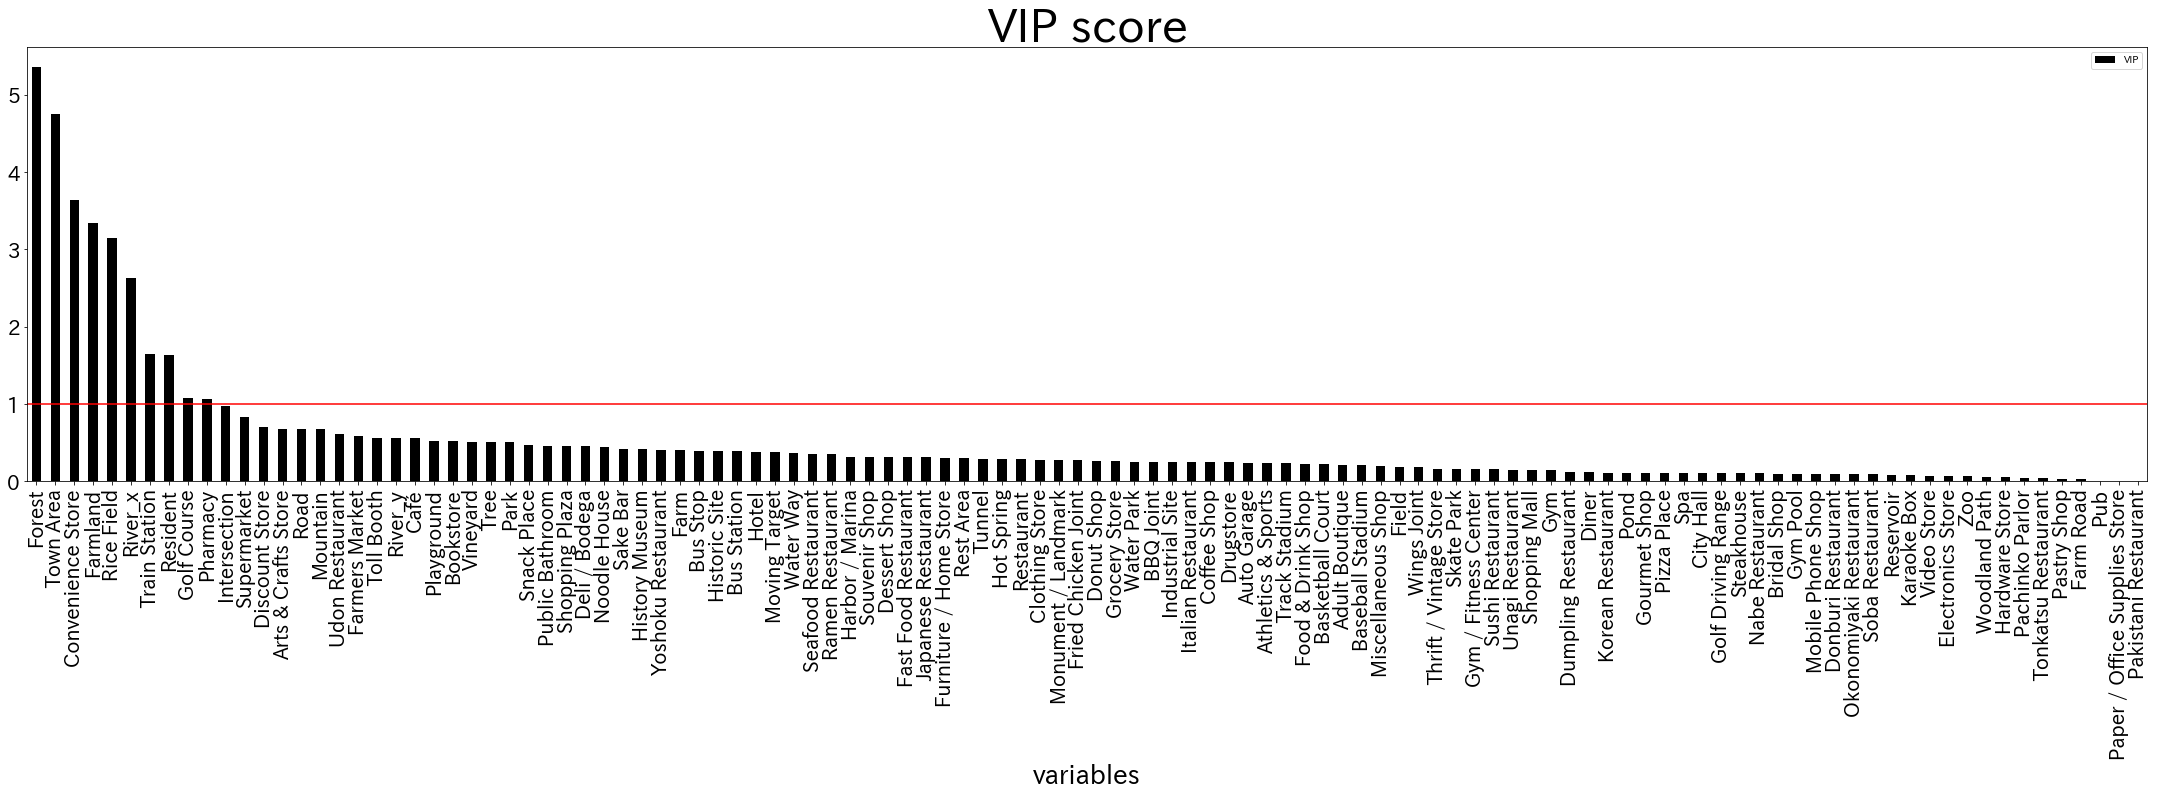

In [63]:
axvip=VIPsort.plot(kind='bar',figsize=(38,8),fontsize=20,color='black')
axvip.set_title('VIP score',fontsize=46)
axvip.set_xlabel('variables',fontsize=26)
axvip.axhline(y=1,color='r')

## Discussion

In the current report, it was revealed that cities in Fukuoka could be divided into 5 clusters, and Forest, Town area, Convenience store, Farm land, Rice field, River, Train station, Resient, Golf course, and Pharmacy store affect the constructio of clusters. 

The five clusters attributed their features to the degree of developpment of cities, such as metropolice, middle city, small city, rural city, and the other unique city. According to the score plot and weight plot of PLS-DA analysis, the four clusters are grouped by PLS components, t1 and t2, and the last cluster was separated by t4. PLS weight plot and VIP scores (the variables whose VIP scores are larger than 1 significantly affect the PLS regression model) indicated that the ratio of Rice field, Farm land, and Train station contributed to the t1/t2  weight plot third quadrant. On the other hand, The ratio of Town area, Resident, Convenience store significantly affect the t1/t2 weight plot second quadrant. Finally, the Ratio of Forest have an impact on t1/t2 weight plot positive dimension, and the ratio of River and Golf course affect t3/t4 weight plot positive dimension. The blue cluster in score plot contains Yanagawa city, Chikugo city, and Kurume city. These areas are developping and are famous for great plane field, which are mainly uused as rice field. The red cluster in score plot contains Fukuoka city a capital of Fukuoka, North-Kyushu city placed an airport, and cities around them as you can see in the cluster mapping result. This areas are highly developped and contained a lot of shopping mole and amusement facilities. The yellow cluster in score plot contains Yame city, Soeda town, and some villages. These area possess enormous nature. Yame city is one of the largest tea garden in Japan. Soeda town is famous for Mt.Hiko, one of the highest mountain in Fukuoka. The green cluster centered in score plot contained middle large cities, which locate around big city as you can see on the cluster mapping result. Therefore, the result of clustering and extraction of features related to each cluster make sense.  
  
 The current analysis enabled people to find unfamiliar cities which fit to their expect when planning a travel or a moving in Fukuoka. The present searching services supplied by a real estate corporattion require people to select the cities to display the detailed information, which cost a lot of time to find the one you want. In some cases you can find the best cities by typing the keyword that you need to live. However, you have to search more detail other than keyword to understand the overall charactristics of the cities or around the cities. In this report, I could cluster the cities in Fukuoka by their similarities of overall description and visualized their location on a map and the important factors which affect the clustering. That enables people to investigate the all cities in Fukuoka all at once. Eventhough the analysis in this report only roughly divide the all cities into 5 clusters which represent the degree of urbanization, the further clustering in the each 5 cluster will enables us to investigate all cities in Fukuoka more closely at once by the a step-by-step searching. 

## Conclusion

In this report, I could divide the all cities in Fukuoka into 5 clusters by k-means clustering, and it was revealed that the degree of urbanization affect the result of clustering by pls-da. This novel analysis enabies you to investigate the overall description of all the cities in Fukuoka at once. It will be possible to search city information in detail through the further cluster analysis of the current 5 clusters.